In [205]:
# imports

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import random
from sklearn.cluster import KMeans
from sqlalchemy import Integer, String, Float
import os
from google.cloud.sql.connector import Connector, IPTypes
import pymysql
import sqlalchemy

In [ ]:
# connecting with GCP

def connect_with_connector() -> sqlalchemy.engine.base.Engine:
    """
    Initializes a connection pool for a Cloud SQL instance of SQL Server.

    Uses the Cloud SQL Python Connector package.
    """
    
    pool = sqlalchemy.create_engine("mysql+pymysql://<user>:<password>@<gcp-cloud-instance>/<db>")
    
    return pool


In [83]:
# Kmeans helper

def kMeans_init_centroids(X, K):
    rand_idx = np.random.permutation(X.shape[0])
    init_centroids = X[rand_idx[:K]]
    return np.array(init_centroids)

In [84]:
# Kmeans helper

def assigning_points_to_centroids(x,centroids):
    m,n = x.shape
    k = centroids.shape[0]
    index = []
    for i in range(m):
        distance = []
        for j in range(k):
            distance.append(np.linalg.norm(x[i]-centroids[j]))
        index.append(np.argmin(distance))
    return np.array(index)

In [85]:
# Kmeans helper

def recomputing_centroids(x,index,k):
    n = x.shape[1]
    new_centroids = []
    for j in range(k):
        points_related_to_cluster_j = x[index == j]
        new_centroids.append(np.mean(points_related_to_cluster_j, axis = 0)) 
    return np.array(new_centroids)

In [86]:
# Kmeans helper

def run_kMeans(X, initial_centroids, max_iters):
    k = initial_centroids.shape[0]
    z = initial_centroids
    for i in range(max_iters):
        indx = assigning_points_to_centroids(X, z)
        centroids = recomputing_centroids(X,indx,k)
        z = centroids
        if i%5 == 0:
            print('iteration{}/{} ====>{} \n'.format(i,max_iters,list(z)))
    return np.array(centroids),np.array(indx)

In [ ]:
# GCP connection object 

conn = connect_with_connector()

In [172]:
# read song table from GCP

song = pd.read_sql("select * from song", conn)

In [173]:
#sample data

song.head()

,id,artist,album_name,song_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,song_genre
0,0000vdREvCVMxbQTkS888c,Rill,Lolly,Lolly,44,160725,1,0.910,0.374,8,-9.844,0,0.1990,0.075700,0.00301,0.1540,0.432,104.042,4,german
1,000CC8EParg64OmTxVnZ0p,Glee Cast,Glee Love Songs,It's All Coming Back To Me Now (Glee Cast Vers...,47,322933,0,0.269,0.516,0,-7.361,1,0.0366,0.406000,0.00000,0.1170,0.341,178.174,4,club
2,000Iz0K615UepwSJ5z2RE5,Paul Kalkbrenner,X,Böxig Leise - Pig & Dan Remix,22,515360,0,0.686,0.560,5,-13.264,0,0.0462,0.001140,0.18100,0.1110,0.108,119.997,4,minimal-techno
3,000qpdoc97IMTBvF8gwcpy,Paul Kalkbrenner,Zeit,Tief,19,331240,0,0.519,0.431,6,-13.606,0,0.0291,0.000964,0.72000,0.0916,0.234,129.971,4,minimal-techno
4,000RDCYioLteXcutOjeweY,Jordan Sandhu,Teeje Week,Teeje Week,62,190203,0,0.679,0.770,0,-3.537,1,0.1900,0.058300,0.00000,0.0825,0.839,161.721,4,hip-hop


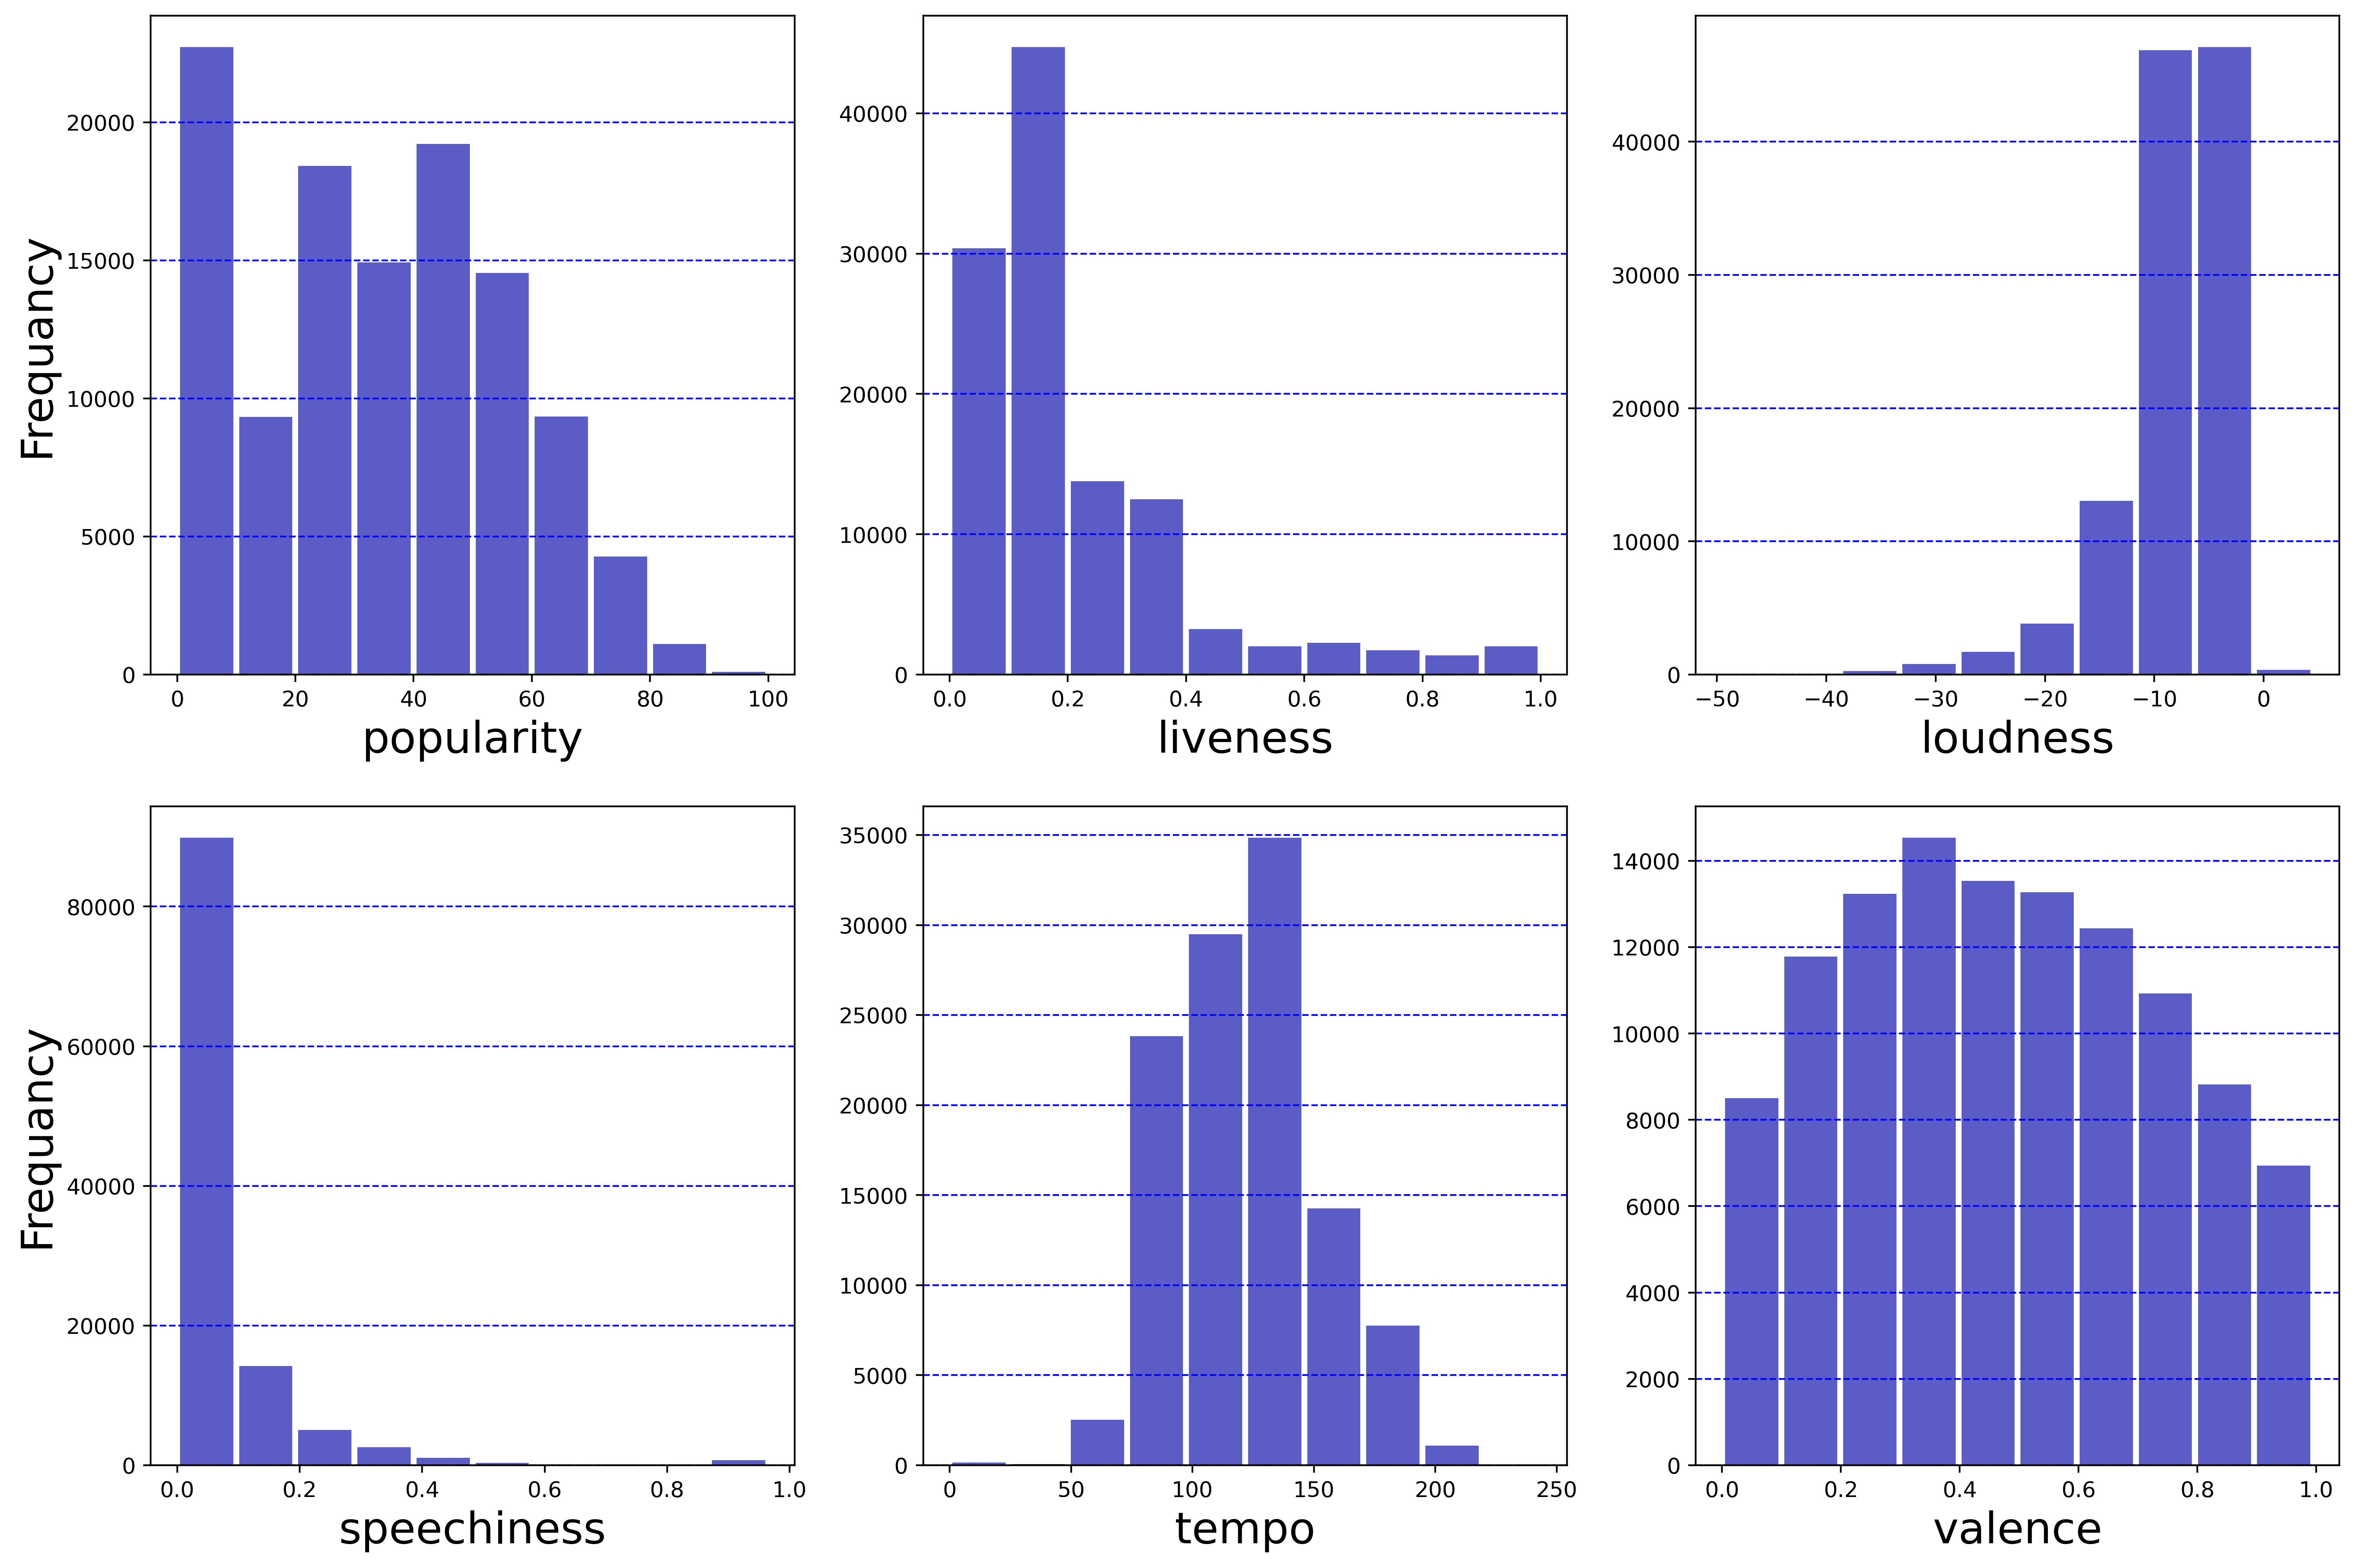

In [174]:
# EDA

features =  ['popularity', 'liveness', 'loudness','speechiness','tempo', 'valence']
l = len(features)
plt.figure(figsize=(18,12),dpi = 400)
for i in range (l):
    plt.subplot(2,3,i+1)
    plt.hist(data[features[i]],color='#0504aa',alpha = 0.65,rwidth=0.9)
    plt.xlabel(features[i],size = 20)
    if i == 0 or i == 3:
        plt.ylabel("Frequancy",size = 20)
        
    plt.xticks()
    plt.yticks()
    plt.grid(axis = "y" , linestyle = "--",color = "b")

In [177]:
# Grouping data by gener then count track_id in each group
df0 = pd.DataFrame(song.groupby(song["song_genre"]).count()["id"]).reset_index()
#sorting values in
df0 = df0.sort_values(by="id",ascending=False)

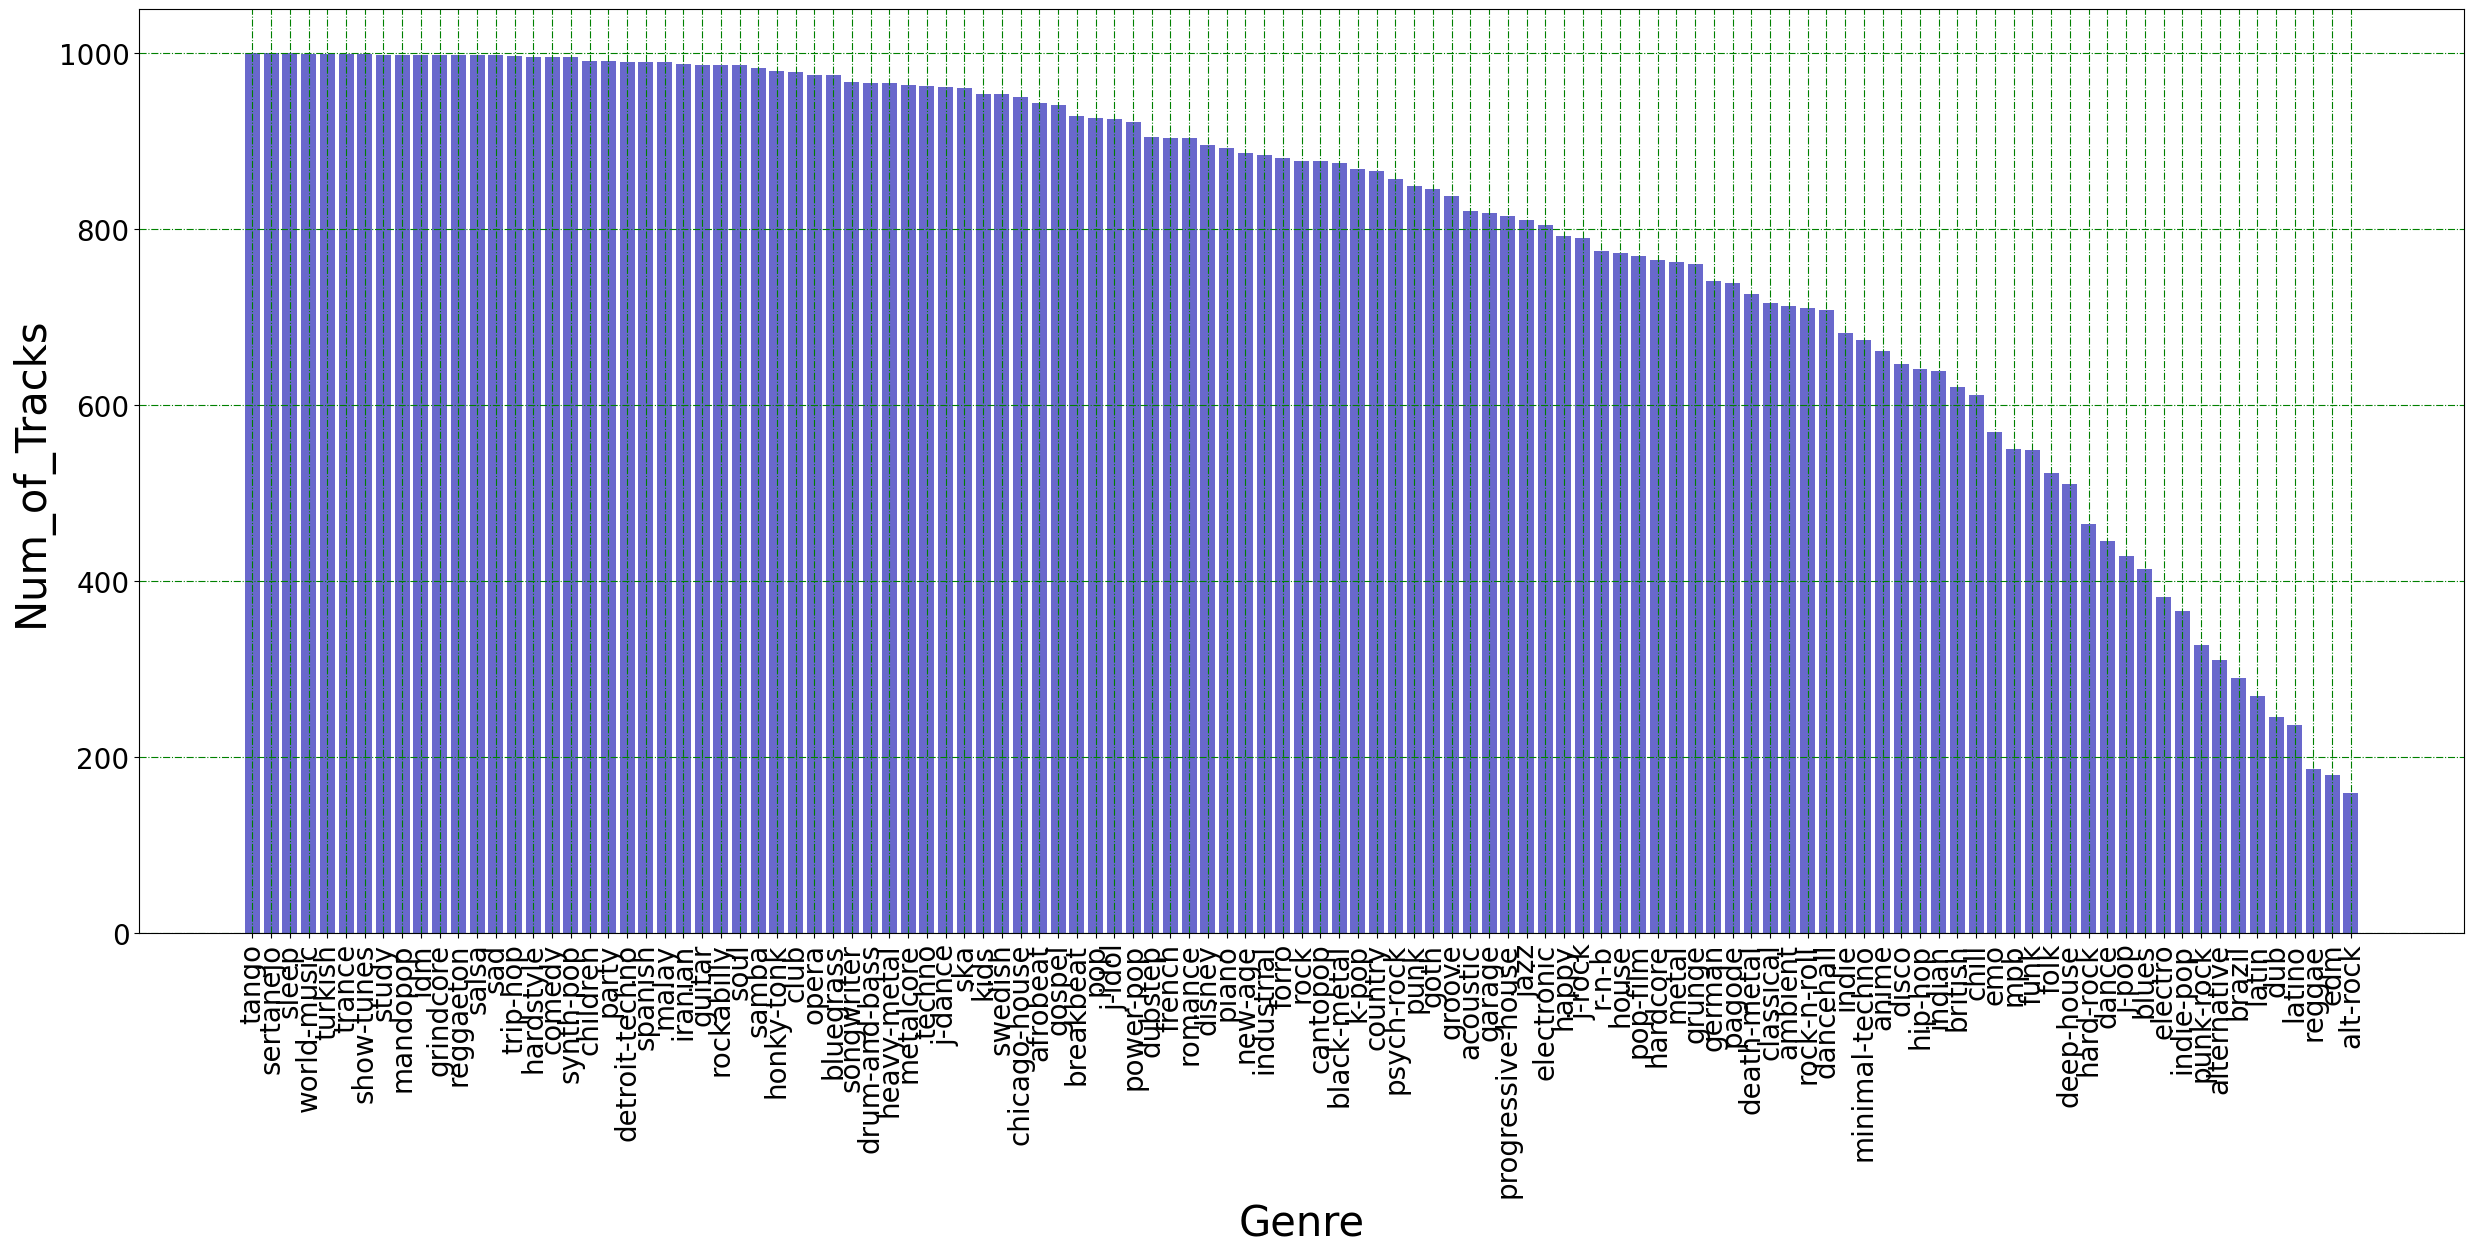

In [180]:
# Plotting no.of tracks in each category

plt.figure(figsize= (30,12))
plt.bar(df0["song_genre"],df0["id"],color = '#0504aa',alpha = 0.6)
plt.xlabel("Genre",size = 30)
plt.ylabel("Num_of_Tracks",size = 30)
plt.xticks(size = 20,rotation='vertical')
plt.yticks(size = 20)
plt.grid(linestyle = '-.',c = "g")
plt.show()

In [181]:
# Encoding genres numerically

genre_ids = [i for i in range(1,115)]
random.shuffle(genre_ids)

genre_mapping = {}
all_genres = list(data['track_genre'].unique())

for i in range(len(all_genres)):
    genre_mapping[all_genres[i]] = genre_ids[i]

print(genre_mapping)
    

{'acoustic': 70, 'afrobeat': 44, 'alt-rock': 31, 'alternative': 47, 'ambient': 89, 'anime': 8, 'black-metal': 2, 'bluegrass': 10, 'blues': 107, 'brazil': 36, 'breakbeat': 98, 'british': 22, 'cantopop': 28, 'chicago-house': 15, 'children': 112, 'chill': 109, 'classical': 63, 'club': 71, 'comedy': 64, 'country': 1, 'dance': 24, 'dancehall': 66, 'death-metal': 78, 'deep-house': 58, 'detroit-techno': 35, 'disco': 21, 'disney': 5, 'drum-and-bass': 92, 'dub': 106, 'dubstep': 45, 'edm': 20, 'electro': 37, 'electronic': 73, 'emo': 7, 'folk': 72, 'forro': 39, 'french': 114, 'funk': 18, 'garage': 38, 'german': 29, 'gospel': 65, 'goth': 40, 'grindcore': 57, 'groove': 30, 'grunge': 54, 'guitar': 52, 'happy': 86, 'hard-rock': 75, 'hardcore': 23, 'hardstyle': 19, 'heavy-metal': 77, 'hip-hop': 96, 'honky-tonk': 69, 'house': 34, 'idm': 55, 'indian': 12, 'indie-pop': 67, 'indie': 43, 'industrial': 79, 'iranian': 68, 'j-dance': 80, 'j-idol': 93, 'j-pop': 91, 'j-rock': 4, 'jazz': 61, 'k-pop': 62, 'kids':

In [182]:
# Map song genre to numerical values

song["genre"] = song["song_genre"].str.lower().map(genre_mapping)

In [185]:
song.columns

Index(['id', 'artist', 'album_name', 'song_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'song_genre', 'genre'],
      dtype='object')

In [187]:
df1 = song.drop(columns=['album_name', 'song_genre', 'artist', 'song_name', 'id', 'key', "time_signature"])
df1

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,44,160725,1,0.910,0.374,-9.844,0,0.1990,0.075700,0.003010,0.1540,0.432,104.042,29
1,47,322933,0,0.269,0.516,-7.361,1,0.0366,0.406000,0.000000,0.1170,0.341,178.174,71
2,22,515360,0,0.686,0.560,-13.264,0,0.0462,0.001140,0.181000,0.1110,0.108,119.997,102
3,19,331240,0,0.519,0.431,-13.606,0,0.0291,0.000964,0.720000,0.0916,0.234,129.971,102
4,62,190203,0,0.679,0.770,-3.537,1,0.1900,0.058300,0.000000,0.0825,0.839,161.721,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,22,144973,0,0.263,0.957,-6.887,1,0.0897,0.000023,0.006300,0.3780,0.204,172.932,49
89737,5,245186,0,0.389,0.540,-5.879,0,0.0285,0.809000,0.000000,0.1320,0.463,159.877,101
89738,42,219200,0,0.679,0.673,-7.504,0,0.0262,0.039200,0.000437,0.0690,0.854,113.970,81
89739,28,207866,0,0.751,0.839,-7.551,1,0.0490,0.523000,0.000000,0.2400,0.730,91.084,13


In [188]:
#data preprocessing 

df1.loc[df1["mode"] == "Major" ,"mode"] = 1
df1.loc[df1["mode"] == "Minor" ,"mode"] = 0
x = np.array(df1)

In [189]:
#scaling features 

df1["popularity"] = df1["popularity"] / max(df1["popularity"])
df1["duration_ms"] = df1["duration_ms"] /max(df1["duration_ms"])
df1["tempo"] = df1["tempo"] /max(df1["tempo"])
df1["loudness"] = df1["loudness"] /max(df1["loudness"])

In [190]:
# Identify ideal clusters

wcss = []
for i in range(1,16):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)


C:\Users\somic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\somic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\somic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\somic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

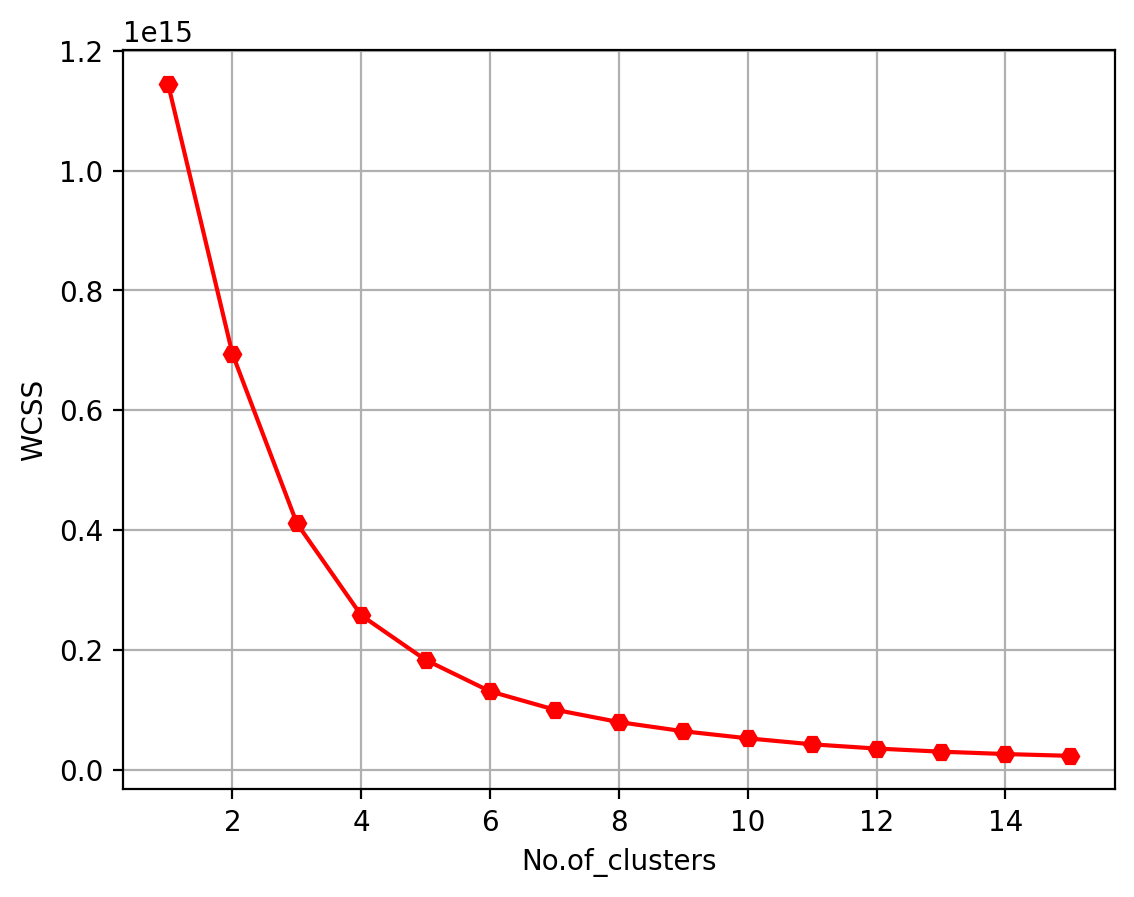

In [192]:
plt.figure(dpi = 200)
plt.plot(np.arange(1,16),wcss,marker = "H",color = "r")
plt.xlabel("No.of_clusters")
plt.ylabel("WCSS")

plt.grid()
plt.show()

In [193]:
# Initialise K means centroids

initial_centroids = kMeans_init_centroids(x, 15)
print('initial centroids ====>\n{} \n'.format(initial_centroids))

initial centroids ====>
[[ 2.00000e+01  1.61053e+05  1.00000e+00  6.61000e-01  6.06000e-01
  -8.40100e+00  0.00000e+00  3.59000e-01  5.50000e-01  0.00000e+00
   8.66000e-02  7.69000e-01  1.37542e+02  8.00000e+01]
 [ 4.40000e+01  2.10679e+05  0.00000e+00  4.25000e-01  9.41000e-01
  -2.32600e+00  1.00000e+00  7.70000e-02  3.10000e-05  1.68000e-02
   4.09000e-01  2.82000e-01  9.74980e+01  9.30000e+01]
 [ 7.10000e+01  2.32853e+05  0.00000e+00  7.46000e-01  4.50000e-01
  -8.54300e+00  1.00000e+00  8.73000e-02  4.07000e-02  0.00000e+00
   1.72000e-01  3.36000e-01  9.59980e+01  3.70000e+01]
 [ 3.40000e+01  1.66671e+05  0.00000e+00  8.55000e-01  4.84000e-01
  -6.89400e+00  1.00000e+00  5.14000e-02  3.69000e-02  7.45000e-03
   1.28000e-01  9.23000e-01  1.32049e+02  8.80000e+01]
 [ 5.60000e+01  1.52028e+05  0.00000e+00  6.62000e-01  5.09000e-01
  -1.07920e+01  1.00000e+00  8.60000e-02  3.46000e-01  6.12000e-03
   3.07000e-01  3.26000e-01  1.05018e+02  1.14000e+02]
 [ 5.50000e+01  2.39893e+05  1.

In [194]:
centroids,idx = run_kMeans(x, initial_centroids,15)

iteration0/15 ====>[array([ 3.26921304e+01,  1.60329555e+05,  1.27099111e-01,  5.99967797e-01,
        5.96180797e-01, -8.61121633e+00,  6.64471518e-01,  9.55545933e-02,
        4.00224601e-01,  1.31564598e-01,  2.10483075e-01,  5.29793125e-01,
        1.21269220e+02,  5.68291077e+01]), array([ 3.48878279e+01,  2.03164321e+05,  9.72440469e-02,  5.77813175e-01,
        6.66036730e-01, -7.50547365e+00,  6.31814336e-01,  8.60895262e-02,
        2.94798591e-01,  1.01733216e-01,  2.16075864e-01,  4.95065069e-01,
        1.22767623e+02,  5.89213707e+01]), array([ 3.61119581e+01,  2.30873331e+05,  6.66984278e-02,  5.63984707e-01,
        6.67475294e-01, -7.39174512e+00,  6.44592663e-01,  7.79513101e-02,
        2.82877095e-01,  9.26331016e-02,  2.07743068e-01,  4.65656230e-01,
        1.22816426e+02,  5.83554073e+01]), array([ 3.34810096e+01,  1.76769678e+05,  1.13145951e-01,  5.90527900e-01,
        6.23551105e-01, -8.10222151e+00,  6.34843538e-01,  9.17042599e-02,
        3.53335178e-01,  1

In [217]:
# Kmeans results

generated_playlists = pd.DataFrame()

for i in range(20):
    x = pd.DataFrame(song.iloc[idx == i ] )
    x.drop_duplicates(keep='first', inplace=True)
    x["playlist_no"] = i
    x = x.nlargest(20, 'popularity')
    generated_playlists = pd.concat((generated_playlists,x))

In [220]:
generated_playlists[generated_playlists["playlist_no"] == 0]

,id,artist,album_name,song_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,song_genre,genre,playlist_no
41516,3nqQXoyQOWXiESFLlDF1hG,Sam Smith,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,0,0.714,0.472,2,...,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,pop,83,0
67868,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,0,0.835,0.679,7,...,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,reggaeton,87,0
52248,4LRPiXqCikLlN15c3yImP7,Harry Styles,As It Was,As It Was,95,167303,0,0.520,0.731,6,...,0.0557,0.34200,0.001010,0.3110,0.662,173.930,4,pop,83,0
6318,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,0,0.881,0.592,2,...,0.0324,0.61900,0.000013,0.0901,0.719,101.058,4,pop,83,0
48640,4C6Uex2ILwJi9sZXRdmqXp,Nicki Minaj,Super Freaky Girl,Super Freaky Girl,92,170977,1,0.950,0.891,2,...,0.2410,0.06450,0.000018,0.3090,0.912,133.010,4,hip-hop,96,0
49335,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,Harry's House,As It Was,92,167303,0,0.520,0.731,6,...,0.0557,0.34200,0.001010,0.3110,0.662,173.930,4,pop,83,0
4715,0HqZX76SFLDz2aW8aiqi7G,Imagine Dragons,Bones,Bones,89,165264,0,0.773,0.742,5,...,0.0460,0.02060,0.000000,0.0754,0.571,114.071,4,rock,104,0
54770,4SqWKzw0CbA05TGszDgMlc,The Walters,I Love You So,I Love You So,89,160239,0,0.575,0.648,10,...,0.0358,0.58300,0.000000,0.1150,0.466,75.977,4,indie,43,0
73871,6I3mqTwhRpn34SLVafSH7G,Justin Bieber,Justice,Ghost,88,153190,0,0.601,0.741,2,...,0.0478,0.18500,0.000029,0.4150,0.441,153.960,4,pop,83,0
1483,086myS9r57YsLbJpU0TgK9,Arctic Monkeys,AM,Why'd You Only Call Me When You're High?,87,161123,0,0.691,0.631,2,...,0.0368,0.04830,0.000011,0.1040,0.800,92.004,4,rock,104,0


In [229]:
# Assign dtypes to store data back to MySQL

sql_dtypes = {
   'id': String(200), 'artist': String(200) , 'album_name': String(200), 'song_name': String(200), 'popularity': Integer, 'explicit': Integer,
       'key': Integer, 'mode': Integer, 'time_signature': Integer, 'song_genre': String(200), 'genre': Integer, 'playlist_no': Integer,
    'acousticness': Float,
 'danceability': Float,
 'duration_ms': Integer,
 'energy': Float,
 'instrumentalness': Float,
 'liveness': Float,
 'loudness': Float,
 'speechiness': Float,
 'tempo': Float,
 'valence': Float
} data 

In [231]:
# Writing data back to MySQL

generated_playlists.to_sql("curated_playlists", conn, dtype = sql_dtypes, index=False, if_exists='replace')

300